# Tutorial 7: Classification (Part II)


## Handwritten Digit Classification using R

<img src="https://media.giphy.com/media/UwrdbvJz1CNck/giphy.gif" width = "600"/>

Source: https://media.giphy.com/media/UwrdbvJz1CNck/giphy.gif

MNIST is a computer vision dataset that consists of images of handwritten digits like these:

![](img/MNIST.png)

It also includes labels for each image, telling us which digit it is. For example, the labels for the above images are 5, 0, 4, and 1.


In this tutorial, we’re going to train a classifier to look at images and predict what digits they are. Our goal isn’t to train a really elaborate model that achieves state-of-the-art performance, but rather to dip a toe into using classification with pixelated images. As such, we’re going to keep working with the simple K-nearest neighbour classifier we have been exploring in the last two weeks.



### Using image data for classification

As mentioned earlier, every MNIST data point has two parts: an image of a handwritten digit and a corresponding label. Both the training set and test set contain images and their corresponding labels.

Each image is 28 pixels by 28 pixels. We can interpret this as a big matrix of numbers:

<img src="img/MNIST-Matrix.png" width = "500"/>


We can flatten this matrix into a vector of 28x28 = 784 numbers and give it a class label (here 1 for the number one). It doesn’t matter how we flatten the array, as long as we’re consistent between images. From this perspective, the MNIST images are just a bunch of points in a 784-dimensional vector space, with a very rich structure.

<img src="img/matrix_to_row.png" width = "1000"/>


We do this for every image of the digits we have, and we create a data table like the one shown below that we can use for classification. Note, like any other classification problem that we have seen before, we need many observations for each class. This problem is also a bit different from the first classification problem we have encountered (Wisonsin breast cancer data set), in that we have more than two classes (here we have 10 classes, one for each digit from 0 to 9).

<img src="img/data_table.png" width = "700"/>

This information is taken from: https://tensorflow.rstudio.com/tensorflow/articles/tutorial_mnist_beginners.html

In [8]:
###
### Run this cell before continuing.
###

library(repr)
library(tidyverse)
library(caret)
source('tests_tutorial_07.R')
source("cleanup_tutorial_07.R")

# functions needed to work with images
# code below sourced from: https://gist.github.com/daviddalpiaz/ae62ae5ccd0bada4b9acd6dbc9008706
# helper function for visualization
show_digit = function(arr784, col = gray(12:1 / 12), ...) {
  image(matrix(as.matrix(arr784[-785]), nrow = 28)[, 28:1], col = col, ...)
}


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches




**Question 1.0** Multiple Choice:
<br> {points: 1}

How many rows and columns does the array of an image have?

A. 784 columns and 1 row

B. 28 columns and 1 row

C. 18 columns and 18 rows

D. 28 columns and 28 rows 

*Assign your answer to an object called `answer1.0`.*

In [9]:
# Make sure the correct answer is an uppercase letter. 
# Surround your answer with quotation marks.
# Replace the fail() with your answer. 

# your code here
answer1.0 = 'D'

In [10]:
test_1.0()

[1] "Success!"


**Question 1.1** Multiple Choice: 
<br> {points: 1}

Once we linearize the array, how many rows represent a number?

A. 28

B. 784

C. 1

D. 18

*Assign your answer to an object called `answer1.1`.*

In [16]:
# Make sure the correct answer is an uppercase letter. 
# Surround your answer with quotation marks.
# Replace the fail() with your answer. 

# your code here
answer1.1 = 'C'

In [17]:
test_1.1()

[1] "Success!"


## 2. Exploring the Data

Before we move on to do the modeling component, it is always required that we take a look at our data and understand the problem and the structure of the data well. We can start this part by loading the images and taking a look at the first rows of the dataset. You can load the data set by running the cell below. 

In [18]:
# Load images. 
# Run this cell. 
training_data <- read.csv('data/mnist_train_small.csv')
testing_data  <- read.csv('data/mnist_test_small.csv')

Look at the first 6 rows of `training_data`. What do you notice?

In [19]:
head(training_data)

,X,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,5,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,6,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


There are no class labels! This data set has already been split into the X's (which you loaded above) and the labels, which you will load by running the cell below. 

In [20]:
# Next, we will load the labels.
# Run this cell. 
training_labels <- read_csv('data/mnist_train_label_small.csv')['y'] %>% mutate(y = as.factor(y))
testing_labels  <- read_csv('data/mnist_test_label_small.csv')['y'] %>% mutate(y = as.factor(y))

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_double(),
  y = col_double()
)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_double(),
  y = col_double()
)



Look at the first 6 labels of `training_labels` using the `head()` function. 

In [21]:
# Use this cell to view the first 6 labels.
# Run this cell.
head(training_labels)

y
<fct>
5
0
4
1
9
2


**Question 2.0**
<br> {points: 1}

How many rows does the training data set have? Note, each row is a different number in the postal code system. 

Use `nrow()`. Note, the testing data set should have fewer rows than the training data set.

*Assign your answer to an object called `number_of_rows`.*

In [23]:
# your code here
# fail() # No Answer - remove if you provide an answer
number_of_rows = nrow(training_labels)
number_of_rows

digest(600)

[1] 600

[1] "6bf5bcbbd708448ba794e031cc180b52"

In [24]:
test_2.0()

[1] "Success!"


**Question 2.1**
<br> {points: 1}

For mutli-class classification with k-nn it is important for the classes to have about the same number of observations in each class. For example, if  90% of our training set observationas were labeled as 2's, then k-nn classification predict 2 almost every time and we would get an accuracy score of 90% even though our classifier wasn't really doing a great job. 

Use the `group_by` and `summarize` function to get the counts for each group and see if the data set is balanced across the classes (has roughly equal numbers of observation for each class). Name the output `counts`. `counts` should be a data frame with 2 columns, `y` and `n` (the column `n` should have the counts for how many observations there were for each class group).

In [37]:
# your code here
# fail() # No Answer - remove if you provide an answer
counts = training_labels %>%
    group_by(y) %>%
    summarize(n = n())
counts

y,n
<fct>,<int>
0,58
1,79
2,64
3,59
4,59
5,51
6,54
7,62
8,49


In [38]:
test_2.1()

[1] "Success!"


**Question 2.2**
<br> {points: 3}

Are the classes roughly balanced? 

The classes are roughly balanced (despite y = 1 having a higher-than-most n).

To view an image in the notebook, you can use the `show_digit` function (we gave you the code for this function in the first code cell in the notebook, All you have to do to use it is run the cell below). The `show_digit` function takes the row from the dataset whose image you want to produce, which you can obtain using the `slice` function.

The code we provide below will show you the image for the observation in the 200th row from the training data set. 

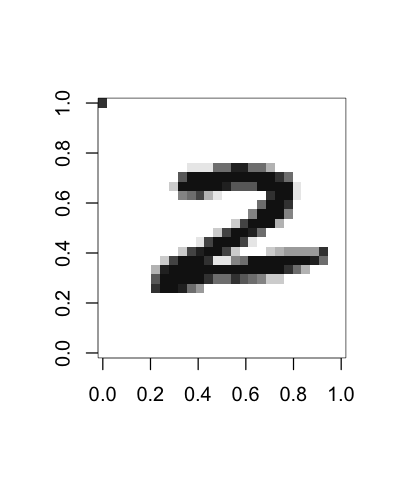

In [39]:
# Run this cell to get the images for the 200th row from the training data set.
options(repr.plot.height = 4, repr.plot.width = 3.3)
show_digit(slice(training_data, 200))

**Question 2.3** 
<br> {points: 3}

Show the image for row 102.

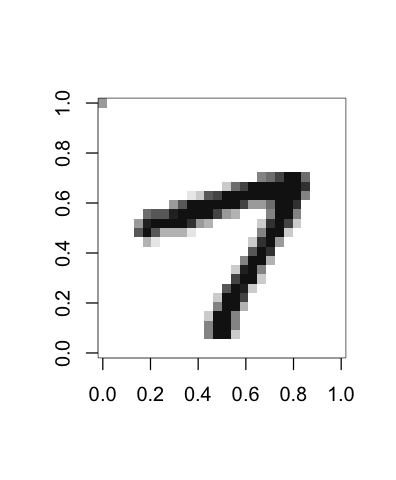

In [41]:
# your code here
options(repr.plot.height = 4, repr.plot.width = 3.3)
show_digit(slice(training_data, 102))

If you are unsure as to what number the plot is depicting (because the handwriting is messy) you can use `slice` to get the label from the `training_labels`:

In [42]:
# run this cell to get the training label for the 200th row
training_labels %>% 
    slice(200)

y
<fct>
2


**Question 2.4** 
<br> {points: 1}

What is the class label for row 102?

*Assign your answer to an object called `label_102`.*

In [ ]:
# Replace the fail() with your answer. 

# your code here
fail() # No Answer - remove if you provide an answer
label_102

In [ ]:
test_2.4()

## 3. Splitting the Data

**Question 3.0**
<br> {points: 3}

Split the training data into `X_train` and `Y_train`. Do the same for the test set. Remember that the `train()` function from the `caret` package requires that the `x` argument a data frame object and the `y` argument a numeric or factor vector. In other words, `X_train` should be a `data.frame` and `Y_train` should be a factor type.

At the end of this question you should have the following 4 data frames:

- `X_train`
- `Y_train`
- `X_test`
- `Y_test`

In [44]:
head(training_data)
head(testing_data)
head(training_labels)

,X,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,5,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,6,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


,X,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,5,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,6,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


y
<fct>
5
0
4
1
9
2


In [47]:
# Set the seed. Don't remove this!
set.seed(9999) 

# your code here
# fail() # No Answer - remove if you provide an answer
X_train = training_data %>%
    select(-X) %>%
    data.frame()
Y_train = training_labels %>%
    unlist()
X_test = testing_data %>%
    select(-X) %>%
    data.frame()
Y_test = testing_labels %>%
    unlist()

**Question 3.1**
<br> {points: 3}

We have already split the data into two datasets, one for training purposes and one for testing purposes. Do you think this is a good idea? If yes, why do we do this? If no, explain why this is not a good idea. 

Yes, it is a good idea. Assuming the split data has been sufficiently shuffled and stratified, it is a good idea to split into training and testing purposes. However, if these assumptions are not true, then it is not a good idea to accept the split up data; rather, you should take the data and split it up yourself.

## Which $k$ should we use?

As you learned from the worksheet, we can use cross-validation on the training data set to select which $k$ is the most optimal for our data set for k-nn classification. 

**Question 3.2**
<br> {points: 3}

To get all the marks in this question, you will have to:
- set a seed to make your analysis reproducible
- Apply 3-fold cross-validation to our small training data
    - Test the following $k$'s: 1, 3, 5, 7, 9, 11
- Plot the $k$ vs the accuracy
    - Assign this plot to an object called `cross_val_plot`
    
*note - this will take 5-15 minutes to run... so we recommend you split the classifier training and cross validation in one cell and plotting into another cell (so you can tweak and re-run the plot code without re-training the classifier each time. Another hint is to make your training data very small, get the code working and then re-run the code with your training data the size you actually want it to be.*

k-Nearest Neighbors 

600 samples
784 predictors
 10 classes: '0', '1', '2', '3', '4', '5', '6', '7', '8', '9' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 540, 540, 541, 540, 542, 540, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.8500830  0.8328298
   3  0.8547293  0.8379376
   5  0.8581137  0.8416584
   7  0.8413613  0.8229343
   9  0.8213247  0.8004813
  11  0.8180733  0.7968352

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 5.

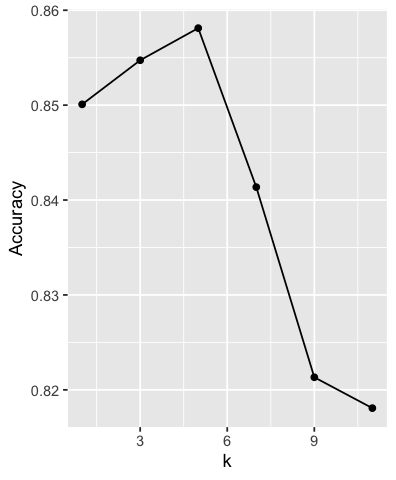

In [55]:
# Set the seed. Don't remove this!
set.seed(1234) 

# your code here
train_control <- trainControl(method = "cv", number = 10)
# makes a column of k's, from 1 to 500 in increments of 5
k_lots = data.frame(k = seq(from = 1, to = 11, by = 2)) 

set.seed(1234)
knn_reg_cv_10 <- train(x = X_train, 
                       y = Y_train, 
                       method = "knn", 
                       tuneGrid = k_lots, 
                       trControl = train_control) 

cross_val_plot = ggplot(knn_reg_cv_10$results, aes(x = k, y = Accuracy)) +
  geom_point() +
  geom_line()
cross_val_plot
knn_reg_cv_10

**Question 3.3**
<br> {points: 3}

Based on the plot from **Question 3.2**, which $k$ would you choose and how can you be sure about your decision? In your answer you should reference why we do cross-validation.

Based on Question 3.2, I would choose k = 5 as it had the highest accuracy (Accuracy = 0.858). It is important to split up the data into training and testing sets and use cross-validation so that we can fine-tune the k-value for the best accuracy in predicting future values. 

## 4. Let's build our model

**Question 4.0**
<br> {points: 3}

Now that we have explored our data, separated the data into training and testing sets and applied cross-validation to choose the best $k$, we can build our final model.

In [57]:
# Set the seed. Don't remove this!
set.seed(9999) 

# your code here
k = data.frame(k = knn_reg_cv_10$bestTune$k)
knn_reg_final <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = k)
knn_reg_final

k-Nearest Neighbors 

600 samples
784 predictors
 10 classes: '0', '1', '2', '3', '4', '5', '6', '7', '8', '9' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 600, 600, 600, 600, 600, 600, ... 
Resampling results:

  Accuracy  Kappa    
  0.812713  0.7906565

Tuning parameter 'k' was held constant at a value of 5

**Question 4.1**
<br> {points: 3}

Use your final model to predict on the test dataset and report the accuracy of this prediction.

In [58]:
# Set the seed. Don't remove this!
set.seed(9999) 

# your code here
# fail() # No Answer - remove if you provide an answer
test_pred <- predict(knn_reg_final, X_test)
modelvalues <- data.frame(obs = Y_test, pred = test_pred)
test_results <- defaultSummary(modelvalues)
test_results

Accuracy     Kappa 
0.7666667 0.7398922

**Question 4.2**
<br> {points: 3}

Print out 3 images and true labels from the test set that were predicted correctly. Use the `show_digit` function we gave you above to print out the images.

[1] 1 3 4 5 6 8

obs,pred
<fct>,<fct>
7,7
1,1
0,0


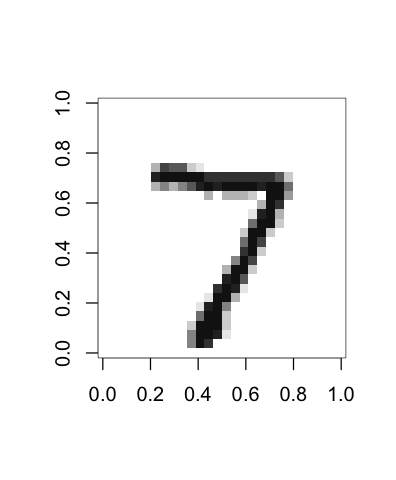

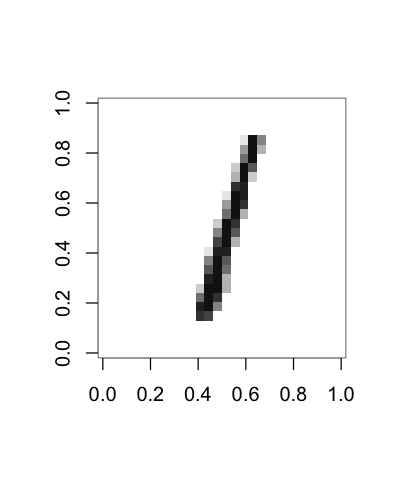

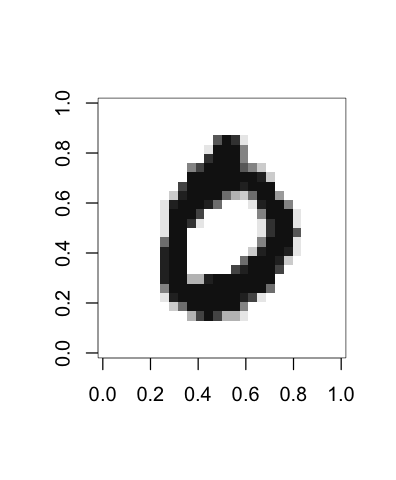

In [93]:
# Set the seed. Don't remove this!
set.seed(1000) 

# your code here
head(which(test_pred == Y_test))
slice(modelvalues,1,3,4)
show_digit(slice(X_test,1))
show_digit(slice(X_test,3))
show_digit(slice(X_test,4))

**Question 4.3**
<br> {points: 3}

Print out 3 images and true labels from the test set that were NOT predicted correctly. For the incorrectly labelled images also print out the predicted labels. Use the `show_digit` function we gave you above to print out the images.

[1]  2  7  9 10 16 27

obs,pred
<fct>,<fct>
2,3
4,9
5,4


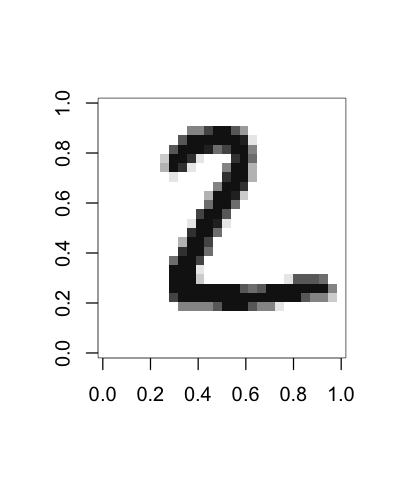

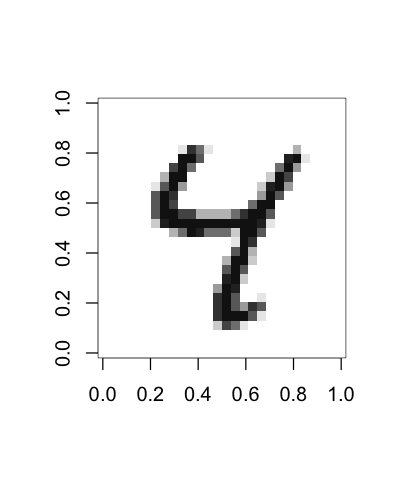

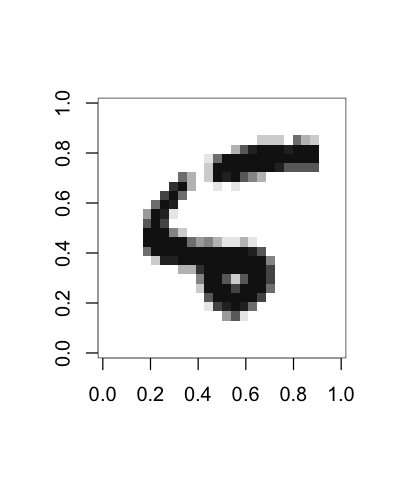

In [92]:
# Set the seed. Don't remove this!
set.seed(300) 

# your code here
# fail() # No Answer - remove if you provide an answer
head(which(test_pred != Y_test))
slice(modelvalues, 2, 7, 9)
show_digit(slice(X_test,2))
show_digit(slice(X_test,7))
show_digit(slice(X_test,9))

**Question 4.4**
<br> {points: 3}

Do you notice any differences between the images that were predicted correctly versus the images that were not?

It seems that the images that were predicted correctly were neatly written with distinct pen endstrokes while the incorrect predictions had poor pen endstrokes. It also looked like the incorrect predictions were closer to handwriting.

**Question 4.5**
<br> {points: 3}

What does this accuracy mean? Is it good enough that you would use this model for the Canada Post? Can you imagine a way we might improve our classifier's accuracy?

The overall accuracy between of the model is 76.7%. This may not be of an acceptable standard for Canada Post. To improve our classifier's accuracy, it may be necessary to train it over a larger dataset or to reduce the k-value.